# Training an Ensemble of probabilistic MC dropouts

This tutorial shows the data preprocessing and model training process for the case of an ensemble of probabilistic MC dropouts.

Important note: The models are trained using `train` data and the hyperparameters should be fine-tuned using `dev_in`.

In [1]:
import json
import torch

print("Torch Version", torch.__version__)

Torch Version 1.10.2+cu102


In [2]:
from vpower.src.utils.auxiliary_functions import load_data_and_set_index
from vpower.src.utils.plot_utils import plot_learning_curve
from vpower.src.utils.scaler import FeatureScaler
from vpower.src.models.mc_dropout import *

# Load data

This tutorial assumes that all data files are placed in a local directory named `../datasets/`.

In [3]:
data_dir = "../datasets/"

In [4]:
train_data = load_data_and_set_index(filepath=data_dir + "train.csv", index_column_name="time_id")
dev_in_data = load_data_and_set_index(filepath=data_dir + "dev_in.csv", index_column_name="time_id")

print("Train records: ", train_data.shape[0])
print("Dev in records: ", dev_in_data.shape[0])

Train records:  530706
Dev in records:  18368


# Data scaling

In [5]:
input_features = ["draft_aft_telegram",
                  "draft_fore_telegram",

                  "stw",
                  "diff_speed_overground",

                  "awind_vcomp_provider",
                  "awind_ucomp_provider",
                  "rcurrent_vcomp",
                  "rcurrent_ucomp",
                  "comb_wind_swell_wave_height",

                  "timeSinceDryDock",
                  ]

target = "power"

scaling_config = {target: "zeta",
                  "draft_aft_telegram": "zeta",
                  "draft_fore_telegram": "zeta",
                  "stw": "zeta",
                  "diff_speed_overground": "zeta",
                  "awind_vcomp_provider": "zeta",
                  "awind_ucomp_provider": "zeta",
                  "rcurrent_vcomp": "zeta",
                  "rcurrent_ucomp": "zeta",
                  "comb_wind_swell_wave_height": "zeta",
                  "timeSinceDryDock": "time"}

In [6]:
scaler = FeatureScaler(config=scaling_config)
scaler.fit(train_data)

train_ds = VPowerDataset(data=train_data,
                         scaler=scaler,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_data,
                       scaler=scaler,
                       input_features=input_features,
                       target=target)

In [7]:
train_ds.norm_df.describe()

,power,draft_aft_telegram,draft_fore_telegram,stw,diff_speed_overground,awind_vcomp_provider,awind_ucomp_provider,rcurrent_vcomp,rcurrent_ucomp,comb_wind_swell_wave_height,timeSinceDryDock
count,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,530706.000000
mean,1.011109e-16,-1.792227e-11,6.768778e-12,-2.022219e-16,-7.410876e-16,-1.581787e-14,4.059819e-14,-2.819110e-16,-7.454790e-17,2.773867e-14,0.224662
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.105628
min,-2.372240e+00,-3.048429e+00,-3.503600e+00,-4.201170e+00,-1.183390e+01,-3.245963e+00,-1.320819e+00,-4.246077e+00,-5.791053e+00,-1.807258e+00,0.002492
25%,-9.651075e-01,-7.589000e-01,-7.674321e-01,-7.325259e-01,-5.351493e-01,-7.487325e-01,-8.111294e-01,-4.072123e-01,-4.385619e-01,-6.912824e-01,0.149662
50%,2.860689e-01,2.166385e-01,2.406296e-01,3.744020e-01,-2.747418e-03,-2.102703e-02,-2.452139e-01,1.641387e-02,-1.809511e-02,-1.126555e-01,0.237851
75%,6.925896e-01,7.674528e-01,8.166648e-01,6.764622e-01,5.888102e-01,7.463498e-01,6.283914e-01,4.111297e-01,4.229756e-01,5.613785e-01,0.314234
max,2.773026e+00,1.630174e+00,1.565511e+00,2.250746e+00,1.182840e+01,2.728355e+00,2.864781e+00,4.208834e+00,5.817410e+00,4.369962e+00,0.401345


In [8]:
val_ds.norm_df.describe()

,power,draft_aft_telegram,draft_fore_telegram,stw,diff_speed_overground,awind_vcomp_provider,awind_ucomp_provider,rcurrent_vcomp,rcurrent_ucomp,comb_wind_swell_wave_height,timeSinceDryDock
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,0.006483,0.004616,0.004437,0.004487,0.006541,0.001634,0.002644,0.003869,-0.007432,-0.003090,0.224919
std,1.005389,1.001647,0.998130,1.001448,1.041296,1.003234,0.997360,0.985902,1.011315,1.003468,0.105971
min,-2.348383,-3.048429,-3.503600,-4.171030,-11.833899,-3.270619,-1.320747,-4.202029,-5.773707,-1.807257,0.002498
25%,-0.957615,-0.758900,-0.623423,-0.729084,-0.357682,-0.752625,-0.804838,-0.400807,-0.442679,-0.693037,0.149464
50%,0.290887,0.216639,0.240630,0.381766,-0.002747,-0.021023,-0.237002,0.017302,-0.020065,-0.115562,0.239435
75%,0.694147,0.767453,0.787863,0.680641,0.588810,0.748325,0.623145,0.407102,0.429664,0.551612,0.314857
max,2.352167,1.630174,1.565511,2.192417,11.828405,2.665629,2.863883,4.190159,5.643564,4.356416,0.401337


# Model training

This tutorial assumes that the trained models and their histories are stored in a local directory named `../my_models/ens_mc_dropout`.

In [9]:
# Model directory to store data
model_dir = "../my_models/ens_mc_dropout"

In [10]:
models_hs = {}

for i in range(1, 11):
    store_path = os.path.join(model_dir, f"member_{i}/")
    if not os.path.exists(store_path):
        os.makedirs(store_path)

    model = ProbMCdropoutDNN(input_size=len(input_features),
                             hidden_size_1=50,
                             hidden_size_2=20,
                             dropout=0.005)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

    history = train(model=model,
                    train_dataset=train_ds,
                    val_dataset=val_ds,
                    optimizer=optimizer,
                    store_path=store_path,
                    batch_size=32,
                    n_epochs=200,
                    es_monitor="val_mae",
                    patience=4)
    models_hs[i] = history

    with open(os.path.join(store_path, f"history.json"), 'w') as jsonfile:
        json.dump(history, jsonfile)

Epoch 0/200
Average train loss: -0.14487550595586005
Average val loss: -0.367193922212263
Val MSE: 0.0666551577375118
Val MAE: 0.1969658877661627
Saved to /home/efi/DeepSea/DeepSeaProjects/DS_dataset_shifts/my_models/ens_mc_dropout/member_1//best_model.pth
Epoch 1/200
Average train loss: -0.3517068587936504
Average val loss: -0.4328944764525114
Val MSE: 0.0599502927480908
Val MAE: 0.1827592846746021
Saved to /home/efi/DeepSea/DeepSeaProjects/DS_dataset_shifts/my_models/ens_mc_dropout/member_1//best_model.pth
Epoch 2/200
Average train loss: -0.4040241674374916
Average val loss: -0.4530033643977256
Val MSE: 0.06444541523914511
Val MAE: 0.1874888870177161
Epoch 3/200
Average train loss: -0.43858954467705963
Average val loss: -0.492155532926996
Val MSE: 0.05747499472043032
Val MAE: 0.17346969358493228
Saved to /home/efi/DeepSea/DeepSeaProjects/DS_dataset_shifts/my_models/ens_mc_dropout/member_1//best_model.pth
Epoch 4/200
Average train loss: -0.46461705114442
Average val loss: -0.512596811

# Learning curves

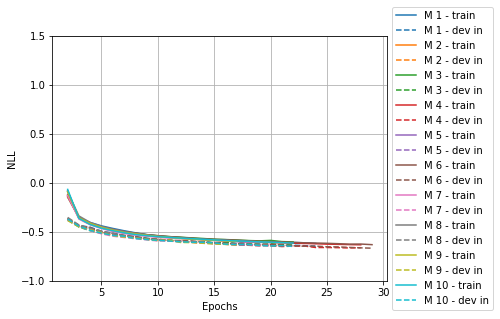

In [12]:
plot_learning_curve(history=models_hs,
                    metric="loss",
                    label="NLL",
                    ylims=(-1, 1.5))

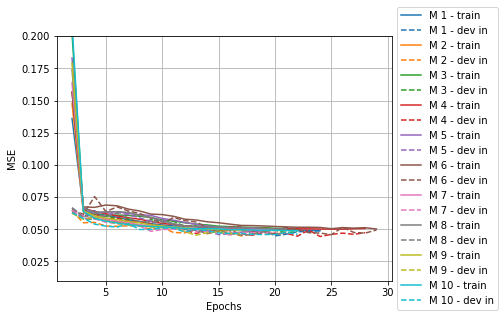

In [13]:
plot_learning_curve(history=models_hs,
                    metric="mse",
                    label="MSE",
                    ylims=(0.01, 0.2))

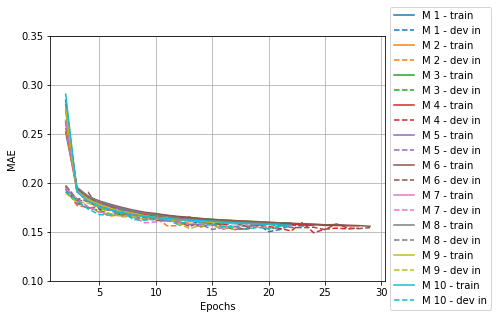

In [14]:
plot_learning_curve(history=models_hs,
                    metric="mae",
                    label="MAE",
                    ylims=(0.1, 0.35))